<a href="https://colab.research.google.com/github/nicolassalomon96/aprendizaje_maquina_UNS/blob/master/TP2/Ejercicio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 - Ejercicio 2

Presentado: Nicolás Salomón - email: nicolassalomon96@gmail.com

Generar un dataset similar al de la pág. 12 de este apunte (dos conjuntos Gaussianos con diferente media y DS, N=50 c/u, uno con etiqueta A y otro con etiqueta B).
Utilizar la curva ROC para proponer un umbral para un clasificador por mínimo error. Evaluar algunos de los parámetros de calidad (exactitud, precisión, f-measure).
Recalcular para algunas variantes (por ejemplo, acercando las medias de los grupos A y B, cambiando el valor umbral, etc.).
Cómo podrían hacer no supervisado este proceso?

# 1. Se importan librerias necesarias y se clonan los datasets del repositorio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# 2. Generación de los datasets

In [3]:
def gen_dataset(media_a, ds_a, media_b, ds_b, features_number, n):
  # Semilla aletoria
  np.random.seed(0)

  a_df = pd.DataFrame(np.random.normal(loc = media_a, scale = ds_a, size=(n, features_number)),
                          columns=['Valor'])
  a_df['Etiqueta'] = 'A'

  b_df = pd.DataFrame(np.random.normal(loc = media_b, scale = ds_b, size=(n, features_number)),
                          columns=['Valor'])
  b_df['Etiqueta'] = 'B'

  return a_df, b_df

features_number = 1
n = 50

media_a = 5 #Media del dataset A
ds_a = 2  #Desviación estandar del dataset A

media_b = 12 #Media del dataset B
ds_b = 4 #Desviación estandar del dataset B

a_df, b_df = gen_dataset(media_a, ds_a, media_b, ds_b, features_number, n)

## 2.1. Gráfica de cada dataset

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


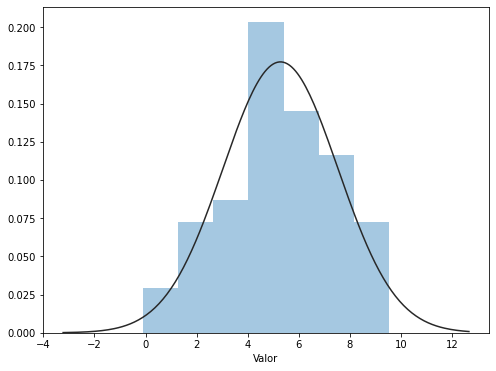

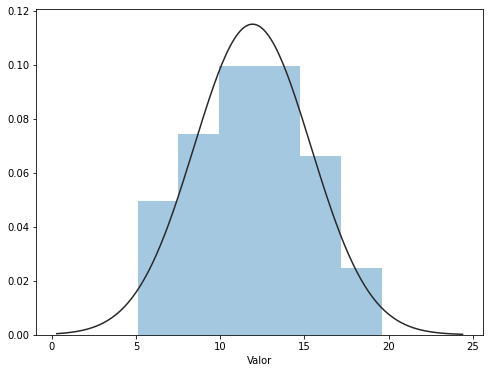

In [4]:
plt.figure(figsize=(8,6))
sns.distplot(a_df['Valor'], fit=norm ,kde=False)

plt.figure(figsize=(8,6))
sns.distplot(b_df['Valor'], fit=norm ,kde=False)

plt.show()

## 2.2. Gráfica de ambos datasets juntos

In [7]:
def merge_dataset(a_df, b_df):
  a_b_df = pd.DataFrame(np.concatenate([a_df['Valor'],b_df['Valor']]), columns=['Valor'])
  a_b_df['Etiqueta'] = np.concatenate([a_df['Etiqueta'],b_df['Etiqueta']])
  a_b_df = a_b_df.sort_values(by='Valor') #Ordenamos el dataset de menor a mayor
  a_b_df = a_b_df.reset_index().drop('index', axis=1) #Reseteamos los indices del dataset ordenado y eliminamos la columna index que posee los indices anteriores al ordenamiento
  
  return a_b_df

a_b_df = merge_dataset(a_df, b_df) 

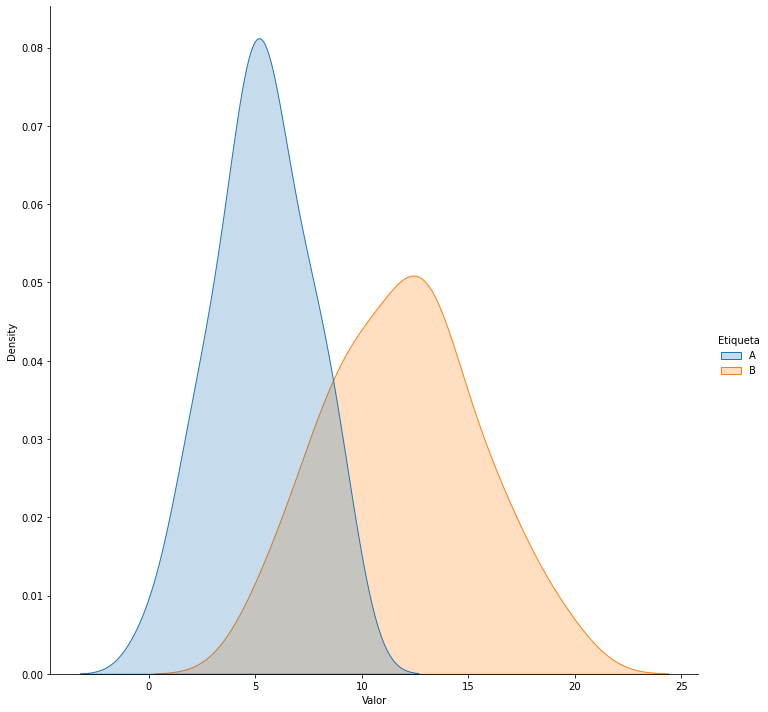

In [8]:
sns.displot(a_b_df, x='Valor', hue = 'Etiqueta', kind = 'kde', fill = True, legend=True, height=10)
plt.show()

# 3. Curva ROC y métricas de medición

## 3.1. Cálculo de métricas de medición

Para graficar la curva ROC vamos a suponer que los valores Verdaderos Positivos (True Positive, TP) son los valores del dataset A, mientras que los valores Falsos Positivos (False Positive) son los valores del dataset B.

In [9]:
def get_metrics (a_b_df):

  ROC_df = a_b_df.copy()
  TP = 0
  FP = 0
  TPR = []
  FPR = []
  TN = []
  FN = []

  accuracy = []
  precision = []
  f_measure = []
  a_count = ROC_df.value_counts(subset=['Etiqueta'])[0] #cantidad de elementos con etiqueta A (TP)
  b_count = ROC_df.value_counts(subset=['Etiqueta'])[1] #cantidad de elementos con etiqueta B (FP)

  for i in range(len(ROC_df)):
    if ROC_df.iloc[i]['Etiqueta'] == 'A':
      TP += 1
    else:
      FP += 1

    TPR.append(TP/(a_count))
    FPR.append(FP/(b_count))
    TN.append(b_count - FP)
    FN.append(a_count - FP)
    
    accuracy.append((TP+TN[i])/(TP + TN[i] + FP + FN[i]))
    precision.append(TP/(TP+FP))
    f_measure.append((2*precision[i]*TPR[i]/(precision[i] + TPR[i]))) #2*precision*recall/(precision+recall)

  TPR = np.asarray(TPR)
  FPR = np.asarray(FPR)
  TN = np.asarray(TN)
  FN = np.asarray(FN)
  accuracy = np.asarray(accuracy)
  precision = np.asarray(precision)
  f_measure = np.asarray(f_measure)

  return TPR, FPR, TP, FP, TN, FN, accuracy, precision, f_measure

TPR, FPR, TP, FP, TN, FN, accuracy, precision, f_measure = get_metrics(a_b_df)

## 3.2. Gráfica de la curva ROC

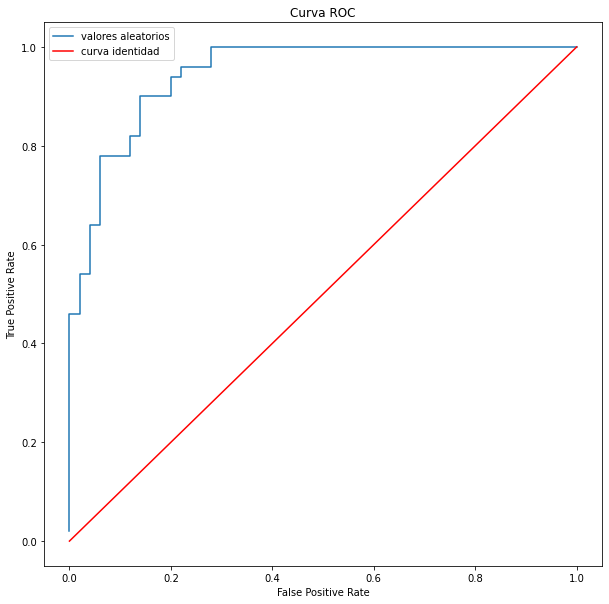

In [10]:
plt.figure(figsize=(10.0,10.0))
plt.plot(FPR,TPR, label='valores aleatorios')
x = np.arange(0,1.1,0.1)
plt.plot(x,x,color='red', label='curva identidad')
plt.title("Curva ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## 3.3. Umbral de mínimo error

Para encontrar el punto mas alejado a la curva identidad (x - y = 0), reemplazamos en la siguiente ecuación los valores de cada punto (x1,y1) de la curva ROC obtenida. Considerando que A = 1, B = -1 y C = 0 de acuerdo a la ecuación de nuestra curva identidad. Luego el punto mas alejado será el mayor valor calculado.

![picture](https://i1.wp.com/lasmatematicas.eu/wp-content/uploads/2017/08/distancia-punto-recta.png?fit=720%2C197&ssl=1)

In [43]:
def get_max_distance(TPR, FPR):
  distance = abs((FPR[:] - TPR[:]) / np.sqrt(2))
  max_distance = np.argwhere(distance == np.amax(distance))
  max_distance = np.squeeze(max_distance)

  return max_distance
  
max_distance = get_max_distance(TPR, FPR)

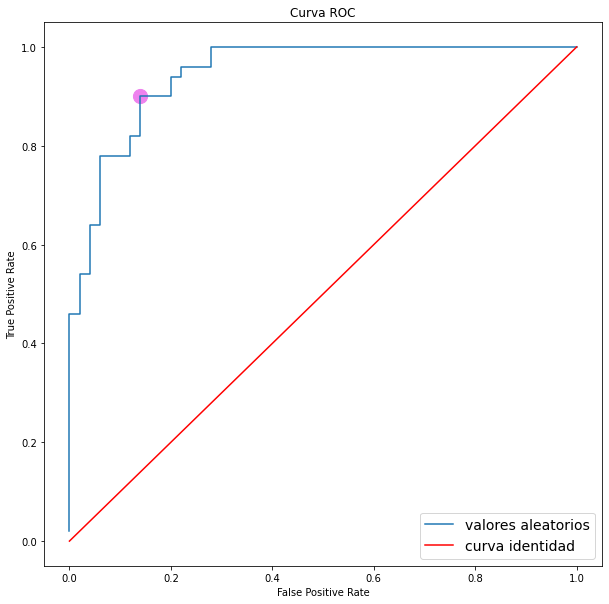


Umbral para tener el mínimo error = 8.065558428716916


In [62]:
def graph_roc(FPR,TPR,max_distance):

  plt.figure(figsize=(10.0,10.0))
  plt.plot(FPR,TPR, label='valores aleatorios')
  x = np.arange(0,1.1,0.1)
  plt.plot(x,x,color='red', label='curva identidad')
  plt.scatter(FPR[max_distance], TPR[max_distance], color='violet', s=200)
  plt.title("Curva ROC")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(fontsize=14)
  plt.show()

  print(f"\nUmbral para tener el mínimo error = {a_b_df['Valor'][max_distance]}")

graph_roc(FPR,TPR,max_distance)

# 4. Exactitud, precisión y f-measure

A continuación se grafican los valores de exactitud, precisión y f-measure, detallando el valor alcanzado utilizando el umbral calculado anteriormente

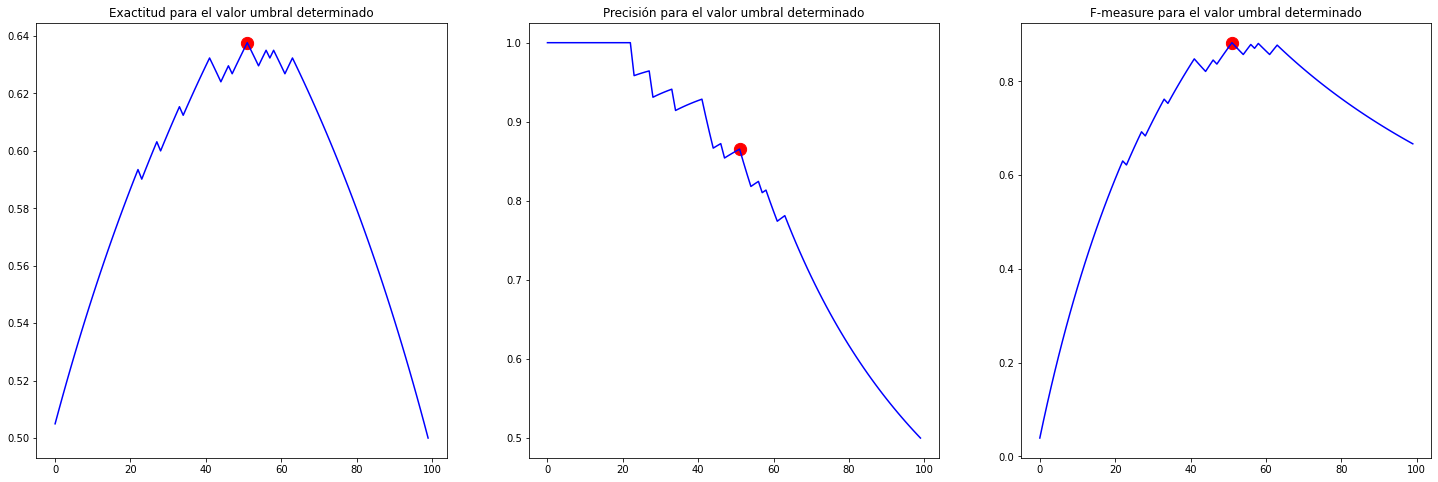

In [66]:
def graph_metrics(accuracy,precision,f_measure,max_distance):

  fig, axs = plt.subplots(1,3,figsize=(25,8))

  plt.subplot(1,3,1)
  plt.plot(accuracy, color='blue')
  plt.scatter(max_distance, accuracy[max_distance], color='red', s=150)
  plt.title("Exactitud para el valor umbral determinado")

  plt.subplot(1,3,2)
  plt.plot(precision, color='blue')
  plt.scatter(max_distance, precision[max_distance], color='red', s=150)
  plt.title("Precisión para el valor umbral determinado")

  plt.subplot(1,3,3)
  plt.plot(f_measure, color='blue')
  plt.scatter(max_distance, f_measure[max_distance], color='red', s=150)
  plt.title("F-measure para el valor umbral determinado")

  plt.show()

graph_metrics(accuracy,precision,f_measure,max_distance)

# 5. Alejamos y acercamos las curvas

## 5.1. Alejamos las curvas

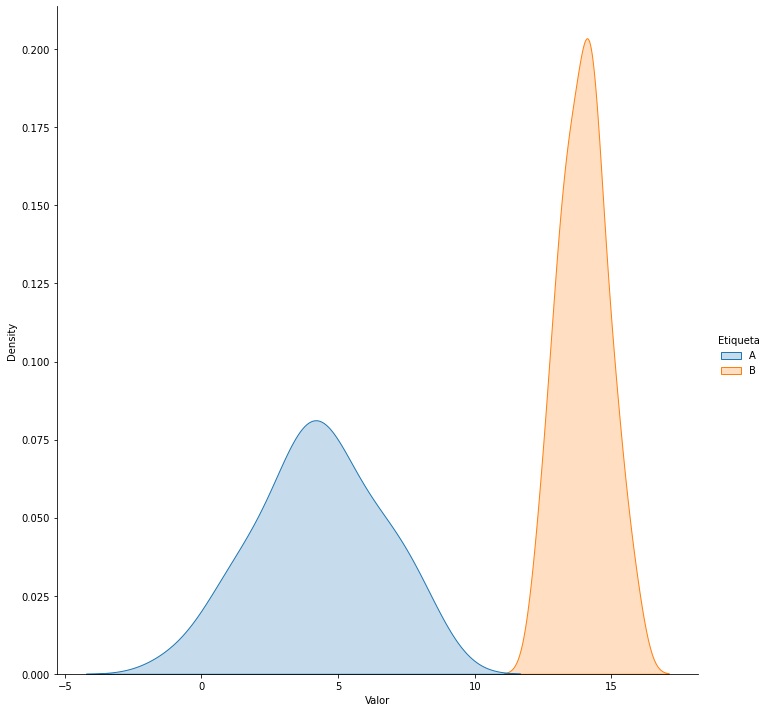

In [31]:
df1, df2 = gen_dataset(media_a=4,ds_a=2,media_b=14,ds_b=1, features_number=1, n=50)
df3 = merge_dataset(df1, df2)

sns.displot(df3, x='Valor', hue = 'Etiqueta', kind = 'kde', fill = True, legend=True, height=10)
plt.show()

TPR1, FPR1, TP1, FP1, TN1, FN1, accuracy1, precision1, f_measure1 = get_metrics(df3)


Umbral para tener el mínimo error = 8.539509247975214


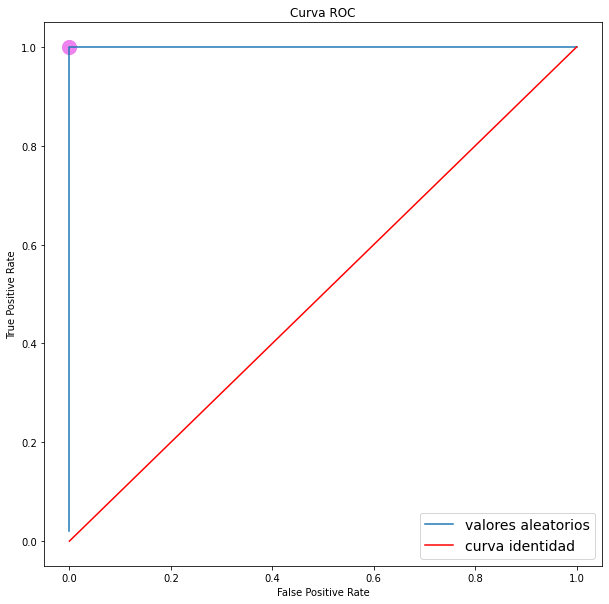


Umbral para tener el mínimo error = 7.93871753980057


In [63]:
max_distance1 = get_max_distance(TPR1, FPR1)
print(f"\nUmbral para tener el mínimo error = {df3['Valor'][max_distance1]}")

graph_roc(FPR1,TPR1,max_distance1)

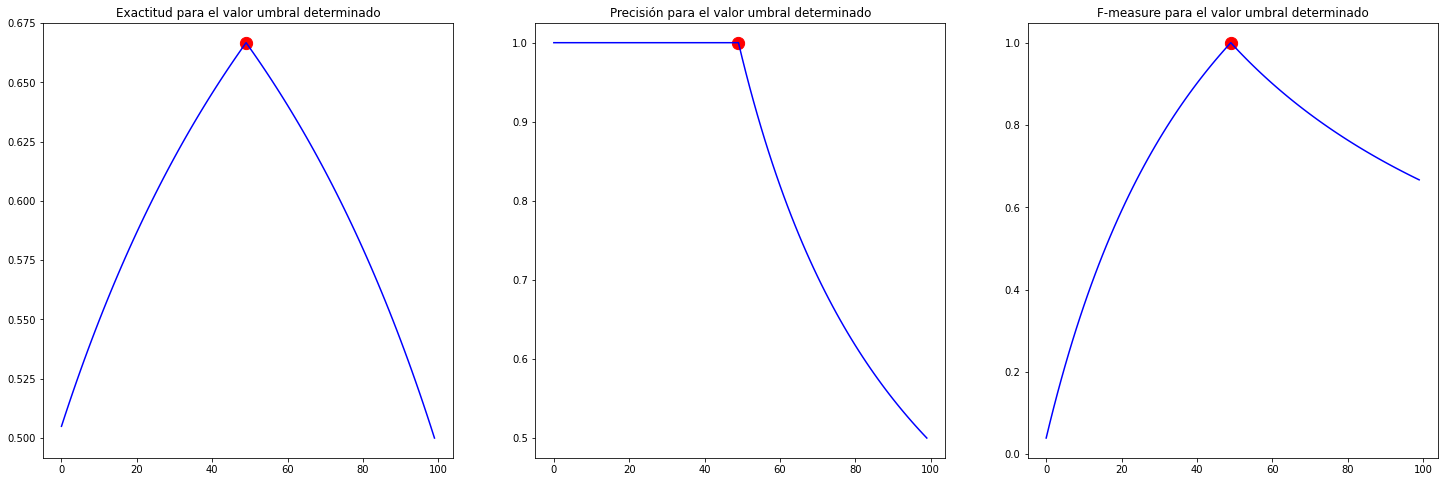

In [67]:
graph_metrics(accuracy1, precision1, f_measure1, max_distance1)

Podemos observar como al alejar las medias hasta el punto en que ambas curvas casi no se intersectan, la curva ROC pasa a ser ideal, asegurándonos una predicción casi ideal, con la mayor precisión y exactitud posible, viéndose reflejado en el valor máximo alcanzado por el f_measure.


# 5.2. Acercamos las curvas

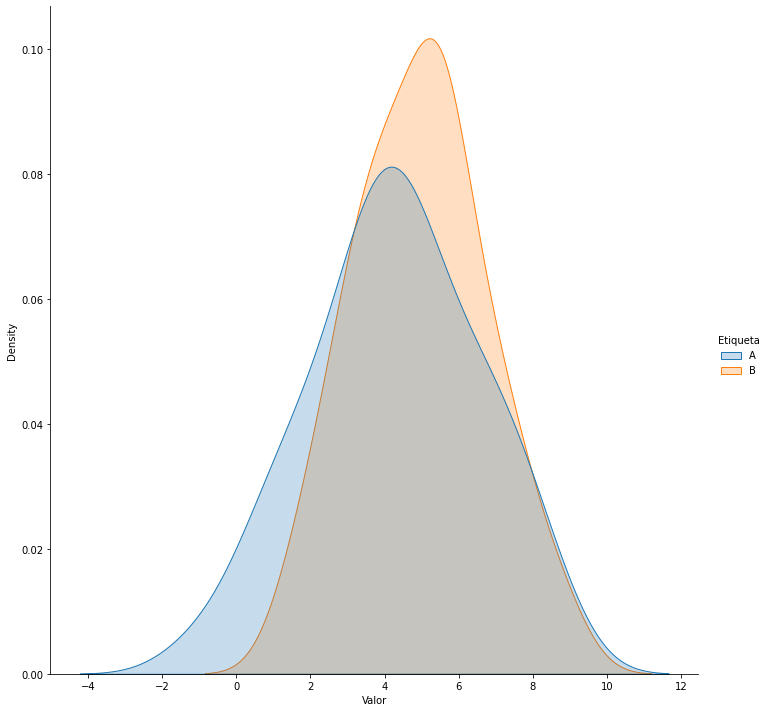

In [41]:
df4, df5 = gen_dataset(media_a=4,ds_a=2,media_b=5,ds_b=2, features_number=1, n=50)
df6 = merge_dataset(df4, df5)

sns.displot(df6, x='Valor', hue = 'Etiqueta', kind = 'kde', fill = True, legend=True, height=10)
plt.show()

TPR2, FPR2, TP2, FP2, TN2, FN2, accuracy2, precision2, f_measure2 = get_metrics(df6)


Umbral para tener el mínimo error = 4.887726465490851


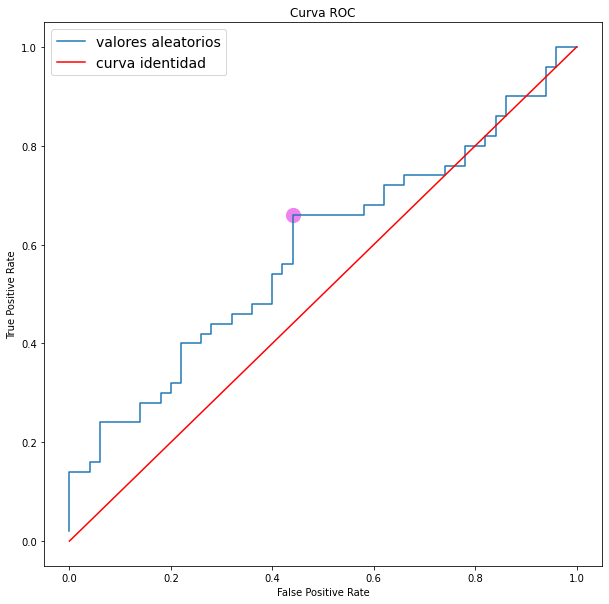


Umbral para tener el mínimo error = 8.516811403272474


In [70]:
max_distance2 = get_max_distance(TPR2, FPR2)
print(f"\nUmbral para tener el mínimo error = {df6['Valor'][max_distance2]}")

graph_roc(FPR2, TPR2, max_distance2)

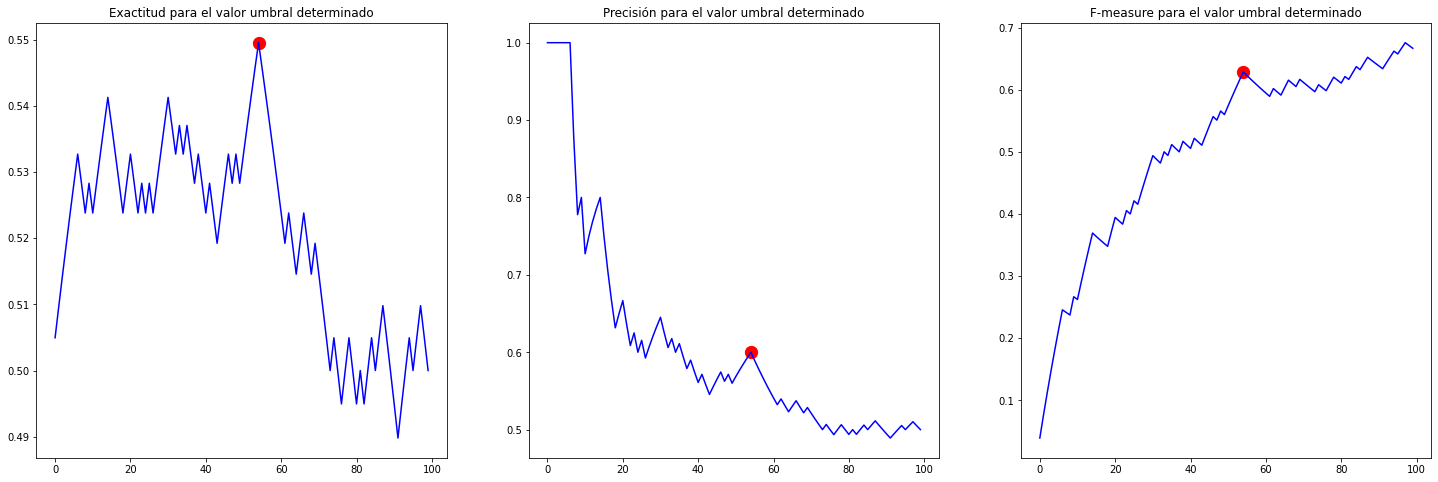

In [71]:
graph_metrics(accuracy2, precision2, f_measure2, max_distance2)

Al acercar las medias podemos observar como la precisión y exactitud bajan considerablemente para el punto de mínimo error (en torno a los 0.55 y 0.6 respectivamente), pero aún así sigue siendo un mejor clasificador que el representado por la curva identidad.